In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

Load Cifar100

In [4]:
dataset = datasets.CIFAR100(root='./data',
                                 train=True,
                                 download=True)

Files already downloaded and verified


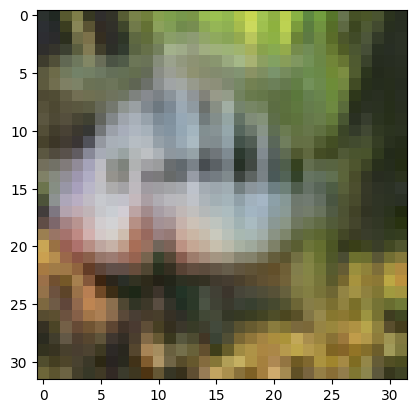

In [13]:
plt.imshow(dataset[4][0])
plt.show()

In [14]:
class MyOwnCifar(torch.utils.data.Dataset):
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

trans_actions = transforms.Compose([transforms.Resize(44),
                                   transforms.RandomCrop(32, padding=4),
                                   transforms.ToTensor()])

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test